`TTbarResProcessor` Notebook for an all hadronic $t\bar{t}$ analysis: 
This notebook contains the processor necessary for analysis and is to be imported into the `TTbarResCoffeaOutputs` module.  To import it, one can ensure that this module can be ran here by executing the notebook.  If everything executes with no errors, one can create a .py file of this module by uncommenting and running the last cell in tis notebook.  That .py file is the module that is imported to create Coffea output files.

   1. Make the mistag rate in the "anti-tag" selection region,
   1. Later apply that mistag rate and the mod-mass procedure to the single-tag (pre-tag) selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag (pret) selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 950$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 
# Quick Reference for Tag Region Definitions:
- An antitag and t-tagged probe pair region; numerator value of mistag [region used for closure test] (Probet)
- An antitag [and any probe pair] region; denominator value; [region used for mistag weights] (at)
- t-tagged jet0 region [region used for data-driven background estimate] (pret)
- No tops tagged (0t)
- Exclusively one jet is top tagged (1t)
- At least one jet is top tagged ['inclusive' tagger; >=1t] (1t+2t)
- Both jets are top tagged (2t)
- Either no tag or at least one tag ['all inclusive' tagger; >=0t] (0t+1t+2t)

In [3]:
executors = ['iterative', 'futures', 'dask', 'iterative test']

executor = executors[3]
print(executor)

iterative test


In [4]:
import copy
import scipy.stats as ss
from coffea import hist, processor, nanoevents
from coffea import util
import numpy as np
import itertools
import pandas as pd
from numpy.random import RandomState

import awkward as ak
#from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

from distributed import Client
import inspect
import json

# import vector

from lpcjobqueue import LPCCondorCluster

from cloudpickle import cloudpickle as cp

/opt/conda/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


In [5]:
import time
import matplotlib.pyplot as plt

In [6]:
# cluster = LPCCondorCluster(scheduler_options={'dashboard':'8785'})
#         # minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
# cluster.adapt(minimum=1, maximum=10)
# client = Client(cluster)


# client
import os

In [ ]:
#ak.behavior.update(nanoaod.behavior)
# ak.behavior.update(candidate.behavior)
ak.behavior.update(vector.behavior)
# vector.register_awkward()

In [ ]:
xrootdstr1 = 'root://cmseos.fnal.gov/'
xrootdstr2 = 'root://cmsxrootd.fnal.gov/'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'
xrootdstr4 = 'root://cms03.lcg.cscs.ch:1094/'
xrootdstr5 = 'root://cms-xrd-global.cern.ch/'
xrootdstr6 = 'root://cms02.lcg.cscs.ch:3128'
xrootdstr7 = 'root://xrootd.t2.ucsd.edu/'
xrootdstr8 = 'root://xrootd-cms.infn.it/'
xrootdstr9 = 'root://mover.pp.rl.ac.uk:1094/'

## Datasets

```
Dataset: /QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/RunIISummer20UL16NanoAOD-FlatPU0to70_106X_mcRun2_asymptotic_v13-v1/NANOAODSIM

Events: 19,883,000


Dataset: /ZprimeToTT_M3000_W30_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/RunIISummer20UL16NanoAOD-106X_mcRun2_asymptotic_v13-v1/NANOAODSIM

Events: 490,008

```

In [ ]:
jsonfiles = {
    'ZPrime':json.load(open('rootFiles/ZPrime_M3000_W30_UL20.json')),
    'QCD':json.load(open('rootFiles/QCD_Pt-15to7000_UL20_xrootd-sites.json')), #json.load(open('rootFiles/QCD_Pt-15to7000_UL20.json')),
    'TTbar':json.load(open('rootFiles/TTbar_UL20.json')),
    'TTjets':json.load(open('rootFiles/TTJets_UL20.json')),
    'Wjets':json.load(open('rootFiles/Wjets_UL20.json')),
    'JetHT':json.load(open('rootFiles/JetHT_Run2016B.json')),
}

rootfiles = {
    'ZPrime':[xrootdstr5 + f for f in jsonfiles['ZPrime']['files']],
    'QCD':[f for f in jsonfiles['QCD']['files']],
#     'QCD':['rootFiles/QCD_pt600to800_customNano_numEvents50000.root'],
    'TTbar':[xrootdstr2 + f for f in jsonfiles['TTbar']['files']],
    'TTjets':[xrootdstr2 + f for f in jsonfiles['TTjets']['files']],
    'Wjets':[xrootdstr2 + f for f in jsonfiles['Wjets']['files']],
    'JetHT':[xrootdstr2 + f for f in jsonfiles['JetHT']['files']],
    'test':'rootFiles/ttbar_Mtt-1000toInf_nEvents50000.root',#'rootFiles/SMttbar_nEvents10000.root'
    
    
}


In [ ]:
rootfiles['QCD']

`manual_bins` is set up to define the bin sizes the user wants for the mistag rates

In [ ]:
manual_bins = [400, 500, 600, 800, 1000, 1500, 2000, 3000, 7000, 10000]

All histograms that one wishes to be included in the Coffea output files is to be defined and filled in this processor.

### Functions
rapidity and deltaR not availabile in current p4 function in awkward1

In [ ]:

def rapidity(fourvector):
    
#     r = .5*np.log( np.divide( (fourvector.p4.energy + fourvector.p4.pz),(fourvector.p4.energy - fourvector.p4.pz) ))
    r = .5*np.log( np.divide( (fourvector.energy + fourvector.pz),(fourvector.energy - fourvector.pz) ))

    return r
    
def deltaR2(fourvector1, fourvector2):
    
    X2 = rapidity(fourvector1)*rapidity(fourvector1) + fourvector1.p4.phi*fourvector1.p4.phi

    Y2 = rapidity(fourvector2)*rapidity(fourvector2) + fourvector2.p4.phi * fourvector2.p4.phi
    
    Z2 = ak.where(X2 > Y2, X2 - Y2, Y2 - X2)
    
    return Z2
    


In [ ]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    

    def __init__(self, prng=RandomState(1234567890), htCut=950., minMSD=105., maxMSD=210.,
                 tau32Cut=0.65, tau32Cut_opt=0.75, deepAK8Cut=0.02, particleNetCut=0.01, ak8PtMin=400., bdisc=0.8484,
                 writePredDist=True,isData=True,year=2019, UseLookUpTables=False, lu=None, 
                 ModMass=False, RandomDebugMode=False):
        
        self.prng = prng
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.tau32Cut_opt = tau32Cut_opt
        self.deepAK8Cut = deepAK8Cut
        self.particleNetCut = particleNetCut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.ModMass = ModMass
        self.RandomDebugMode = RandomDebugMode
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["Probet", "at", "pret", "0t", "1t", "1t+2t", "2t", "0t+1t+2t"] #anti-tag+probe, anti-tag, pre-tag, 0, 1, >=1, 2 ttags, any t-tag
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        #print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        tagcat_axis = hist.Cat("taggerName", "Tagger")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 5000)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 30, 0, 3000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -5, 5)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 5)
        manual_axis = hist.Bin("jetp", r"Jet Momentum [GeV]", manual_bins)
        tagger_axis = hist.Bin("tagger", r"Tagger", 500, 0, 1)
        tau32_axis = hist.Bin("tau32", r"$\tau_3/\tau_2$", 100, 0, 1)
        csvv2_axis = hist.Bin("csvv2", r"CSV v2", 100, 0, 1)
        deltaR_axis = hist.Bin("deltaR", r"$\Delta R$", 50, 0, 5)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -np.pi, np.pi)

        self._accumulator = processor.dict_accumulator({
            
#             'ttbarmass': hist.Hist("Counts", dataset_axis, ttbarmass_axis),
            

            'jetpt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_topmass':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetmass':     hist.Hist("Counts", dataset_axis, jetmass_axis),
            'jetmass_topmass':     hist.Hist("Counts", dataset_axis, jetmass_axis),
            'deltaR':     hist.Hist("Counts", dataset_axis, deltaR_axis),
            'deltaR_matched':     hist.Hist("Counts", dataset_axis, deltaR_axis),
            
            'ttbarcands_pt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_mass':     hist.Hist("Counts", dataset_axis, jetmass_axis),
            
            
            'ttbarcands_pt_tagger_t0.00_b1.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.00_b0.67': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.00_b0.33': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.00_b0.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.33_b1.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.33_b0.67': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.33_b0.33': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.33_b0.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.67_b1.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.67_b0.67': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.67_b0.33': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t0.67_b0.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t1.00_b1.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t1.00_b0.67': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t1.00_b0.33': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_tagger_t1.00_b0.00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            
            'ttbarcands_mass_tagger_t0.00_b1.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.00_b0.67': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.00_b0.33': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.00_b0.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.33_b1.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.33_b0.67': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.33_b0.33': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.33_b0.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.67_b1.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.67_b0.67': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.67_b0.33': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t0.67_b0.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t1.00_b1.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t1.00_b0.67': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t1.00_b0.33': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_tagger_t1.00_b0.00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            
            'ttbarcands_pt_particleNet_1e+00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-01': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-02': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-03': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-04': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-05': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-06': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_1e-07': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_particleNet_0e+00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            
            'ttbarcands_mass_particleNet_1e+00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-01': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-02': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-03': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-04': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-05': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-06': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_1e-07': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_particleNet_0e+00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            
            'ttbarcands_pt_deepAK8_1e+00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-01': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-02': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-03': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-04': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-05': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-06': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_1e-07': hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_pt_deepAK8_0e+00': hist.Hist("Counts", dataset_axis, jetpt_axis),
            
            'ttbarcands_mass_deepAK8_1e+00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-01': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-02': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-03': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-04': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-05': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-06': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_1e-07': hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ttbarcands_mass_deepAK8_0e+00': hist.Hist("Counts", dataset_axis, jetmass_axis),
            
            'h_HOTVR':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_deepAK8':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_particleNet':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_tau32':       hist.Hist("Counts", dataset_axis, jetpt_axis, tau32_axis, csvv2_axis),
            'h_CSVV2':       hist.Hist("Counts", dataset_axis, jetpt_axis, tau32_axis),
       
            'cutflow': processor.defaultdict_accumulator(int),
            
            'deepAK8': processor.defaultdict_accumulator(int),
            'particleNet': processor.defaultdict_accumulator(int),
            'tau32': processor.defaultdict_accumulator(int),
            
            'deepAK8_msdCut': processor.defaultdict_accumulator(int),
            'particleNet_msdCut': processor.defaultdict_accumulator(int),
            'tau32_msdCut': processor.defaultdict_accumulator(int),
            
            'ttjets': processor.defaultdict_accumulator(int),
            'qcdjets': processor.defaultdict_accumulator(int),




            
            'status': processor.column_accumulator(np.array([])),
            'pdgid': processor.column_accumulator(np.array([])),
            
            
            
   
            'jetpt_deepAK8':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_tau32':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_tau32_opt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_particleNet':     hist.Hist("Counts", dataset_axis, jetpt_axis),
       
            
        })
            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        
        skipCuts = True
        
        output = self.accumulator.identity()
        
        # ---- Define dataset ---- #
        dataset = events.metadata['dataset']
        
     
        FatJets = ak.with_name(events.FatJet, "PtEtaPhiMLorentzVector")
        SubJets = ak.with_name(events.SubJet, "PtEtaPhiMLorentzVector")
        GenParts = ak.with_name(events.GenPart, "PtEtaPhiMLorentzVector")
#         GenParts = ak.with_name(events.customGenParticles, "PtEtaPhiMLorentzVector")
#         hotvrJets = ak.with_name(events.HOTVR, "PtEtaPhiMLorentzVector")
        hotvrJets = ak.with_name(events.FatJet, "PtEtaPhiMLorentzVector")
       
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(ak.count(FatJets.pt)) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = events.Generator.weight
        # ---- Show all events ---- #
        output['cutflow']['all events'] = len(FatJets)
        

        # ---- Apply Trigger(s) ---- #
        #FatJets = FatJets[HLT_AK8_trig1]
        #evtweights = evtweights[HLT_AK8_trig1]
        #Jets = Jets[HLT_AK8_trig1]
        #SubJets = SubJets[HLT_AK8_trig1]
        
#         # ---- Jets that satisfy Jet ID ---- #
#         jetIdCut = (FatJets.jetId > 0) # Loose jet ID
        
#         print('jetIdCut', jetIdCut)
#         print('jetIdCut', ak.any(jetIdCut, axis=-1))
        
#         FatJets    = FatJets[jetIdCut]
#         FatJets    = FatJets[ak.any(jetIdCut, axis=-1)]
#         SubJets    = SubJets[ak.any(jetIdCut, axis=-1)]
#         GenParts   = GenParts[ak.any(jetIdCut, axis=-1)]
#         hotvrJets  = hotvrJets[ak.any(jetIdCut, axis=-1)]
        
#         output['cutflow']['jet id'] = len(FatJets)


        
#         # ---- Apply HT Cut ---- #
        
#         passHT = (ak.sum(FatJets.pt, axis=-1) > self.htCut)
#         print('HT', ak.sum(FatJets.pt, axis=-1))
        
#         FatJets = FatJets[passHT]
#         SubJets = SubJets[passHT]
#         GenParts   = GenParts[passHT]
#         hotvrJets  = hotvrJets[passHT]
        
#         output['cutflow']['HT cut'] = len(FatJets)

    
        
        # ---- Apply pT Cut and Rapidity Window ---- #
        FatJets_rapidity = rapidity(FatJets)
         
        etaCut = (np.abs(FatJets_rapidity) < 2.4)
        ptCut = ((FatJets.pt > 600) & (FatJets.pt < 800))
        
        jetkincut_index = (etaCut & ptCut)
        
        
        print('jetkincut_index', jetkincut_index)
        print('jetkincut_index', ak.any(jetkincut_index, axis=-1))
        
        
        FatJets    = FatJets[ jetkincut_index ]
        FatJets    = FatJets[ak.any(jetkincut_index, axis=-1)]
        SubJets    = SubJets[ak.any(jetkincut_index, axis=-1)]
        GenParts   = GenParts[ak.any(jetkincut_index, axis=-1)]
        hotvrJets  = hotvrJets[ak.any(jetkincut_index, axis=-1)]
        
        output['cutflow']['jet kin'] = len(FatJets)
        
        
        # ---- Find two AK8 Jets ---- #
        
        twoFatJetsKin = (ak.num(FatJets) == 2)
        print(twoFatJetsKin)
        FatJets    = FatJets[twoFatJetsKin]
        SubJets    = SubJets[twoFatJetsKin]
        GenParts   = GenParts[twoFatJetsKin]
        hotvrJets  = hotvrJets[twoFatJetsKin]
        
        output['cutflow']['2 FatJets'] = len(FatJets)

        

        
        
#         # create ttbar candidates for msd cut #
        
# #         index = ak.unflatten( np.random.randint(2, size=len(FatJets)), np.ones(len(FatJets), dtype='i') )
#         index = np.random.randint(2, size=len(FatJets))
    
#         print(index)
        
#         jet0 = FatJets[index]
#         jet1 = FatJets[1-index]

        
#         ttbarcands = ak.cartesian([jet0, jet1])
        
        

#         # ---- Make sure we have at least 1 TTbar candidate pair and re-broadcast releveant arrays  ---- #
#         oneTTbar = (ak.num(ttbarcands) >= 1)
        
#         ttbarcands = ttbarcands[oneTTbar]
#         FatJets = FatJets[oneTTbar]
#         SubJets = SubJets[oneTTbar]
#         GenParts = GenParts[oneTTbar]
#         hotvrJets = hotvrJets[oneTTbar]
        
#         output['cutflow']['N ttbar >= 1'] = len(FatJets)
        
#         print('1 ttbar cut')
#         print(len(FatJets))
#         print(len(SubJets))
#         print(len(GenParts))
#         print(len(hotvrJets))
#         print()
        
#         # ---- Remove Jets and TTbar Candidates without Subjets ---- #
#         hasSubjets0 = ((ttbarcands.slot0.subJetIdx1 > -1) & (ttbarcands.slot0.subJetIdx2 > -1))
#         hasSubjets1 = ((ttbarcands.slot1.subJetIdx1 > -1) & (ttbarcands.slot1.subJetIdx2 > -1))
#         GoodSubjets = (hasSubjets0 & hasSubjets1)
        
#         print('2 subjets cut')
#         print(len(ak.any(GoodSubjets, axis=-1)), ak.any(GoodSubjets, axis=-1))
#         print()
        
#         ttbarcands = ttbarcands[GoodSubjets]
        
#         ttbarcands = ttbarcands[(ak.any(GoodSubjets, axis=-1))]
#         SubJets = SubJets[(ak.any(GoodSubjets, axis=-1))]
#         FatJets = FatJets[(ak.any(GoodSubjets, axis=-1))]
#         hotvrJets = hotvrJets[(ak.any(GoodSubjets, axis=-1))]
        
#         output['cutflow']['Subjet Cut'] = len(FatJets)
        
#         print(len(ttbarcands))
#         print(len(FatJets))
#         print(len(SubJets))
#         print(len(GenParts))
#         print(len(hotvrJets))
#         print()
        
        
        if(not skipCuts):
        
            # Mass Cuts (top tagger and HOTVR) #

            FatJets = FatJets[(FatJets.msoftdrop > self.minMSD ) & (FatJets.msoftdrop < self.maxMSD)]
            hotvrJets = hotvrJets[(hotvrJets.mass > 140 ) & (hotvrJets.mass < 220)]

            FatJets = FatJets[ak.any((FatJets.msoftdrop > self.minMSD ) & (FatJets.msoftdrop < self.maxMSD), axis=-1)]

            # HOTVR min mass cut #

            hotvrJets = hotvrJets[(hotvrJets.m_min > 50)]

            # HOTVR require leading subjet pt ratio < 0.8 #

            ptratio = ((hotvrJets.subjet0Pt / hotvrJets.pt) < 0.8)
            hotvrJets = hotvrJets[ptratio]
            hotvrJets = hotvrJets[ak.any(ptratio, axis=-1)]

            output['cutflow']['HOTVR cuts'] += len(hotvrJets)

        

        FatJets_tau32 = np.where(FatJets.tau2 > 0, FatJets.tau3 / FatJets.tau2, 0)

        
        FatJets_deepAK8cut = FatJets[FatJets.deepTag_TvsQCD > self.deepAK8Cut]
        FatJets_tauCut = FatJets[FatJets_tau32 < self.tau32Cut]
        # FatJets_particleNetcut = FatJets[FatJets.particleNet_TvsQCD > self.particleNetCut]

        
        
        # total jets #
        
        output['cutflow']['HOTVR jets'] = ak.count(hotvrJets.pt)
        output['cutflow']['AK8 jets']   = ak.count(FatJets.pt)
        
        print(FatJets.pt)
        
 
        ## plot histograms before matching ##
        
        
        output['jetpt'].fill(dataset = dataset, 
                        jetpt = ak.flatten(FatJets.pt),
                       )
        
        output['jetmass'].fill(dataset = dataset, 
                        jetmass = ak.flatten(FatJets.mass),
                       )

        

        
        
        

        
        FatJets_tau32 = np.where(FatJets.tau2 > 0, FatJets.tau3 / FatJets.tau2, 0)
        hotvrJets_tau32 = np.where(hotvrJets.tau2 > 0, hotvrJets.tau3 / hotvrJets.tau2, 0)

        
        
        
  

        
        
        
#         ttbar = ttbarcands.slot0.add(ttbarcands.slot1)
#         print('ttbar pt', ttbar.pt)
        
#         output['ttbarcands_pt'].fill(dataset = dataset, 
#                                 jetpt = ak.flatten(ttbar.pt),
#                                )
#         output['ttbarcands_mass'].fill(dataset = dataset, 
#                                 jetmass = ak.flatten(ttbar.mass),
#                                )
    

        
        output['h_deepAK8'].fill(dataset = dataset, 
                                tagger = ak.flatten(FatJets.deepTag_TvsQCD),
                                jetpt  = ak.flatten(FatJets.pt),
                                )
        
        
        
        output['h_tau32'].fill(dataset = dataset, 
                                tau32 = ak.flatten(FatJets_tau32),
                                csvv2 = ak.flatten(FatJets.btagCSVV2),
                                jetpt = ak.flatten(FatJets.pt),
                                )
        
        
        output['h_HOTVR'].fill(dataset = dataset, 
                                tagger = ak.flatten(hotvrJets_tau32),
                                jetpt  = ak.flatten(hotvrJets.pt),
                                )
        

        

            
  


        
        
        
        print()
     
        return output

    def postprocess(self, accumulator):
        return accumulator



In [ ]:




if (executor == "dask"):
    if __name__ == "__main__":
        tic = time.time()
        cluster = LPCCondorCluster()
        # minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
        cluster.adapt(minimum=1, maximum=10)
        client = Client(cluster)
#         client.upload_file('TTbarResProcessor_nb.py')

if(executor == "dask"):
    client

In [ ]:
executor=executors[3]
executor

In [ ]:
tstart = time.time()

# chunksize of 100,000 takes iterative executor 2 hrs for QCD


filesets = {
#     'ZPrime':rootfiles['ZPrime'],
    'QCD':rootfiles['QCD'],
#     'TTbar':rootfiles['TTbar'],
#     'Wjets':rootfiles['Wjets'],
#     'test':[rootfiles['test']],

}
# filesets



outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 100] # [chunksize, maxchunks]


for name,files in filesets.items():
    
    if(executor=="dask"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'schema': NanoAODSchema,
#                                               'workers': 2
                                          }
                                          ,
                                          chunksize=100000,
                                         )
        
    elif(executor=="futures"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.futures_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                              'workers': 2
                                          }
                                          ,
                                          chunksize=100000,
#                                           maxchunks=10,
                                         )

    elif(executor=="iterative test"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.iterative_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                              'workers':2
                                          },
                                          chunksize=10000,
                                          maxchunks=10,
                                          
                                         )
        
    else:
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.iterative_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                          },
                                          chunksize=100000,
                                         )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    
    elapsed = time.time() - tstart
    print(elapsed)

    print()

In [ ]:
for key in output['cutflow'].keys():
    tab = '\t'
    if (len(key) < 8): tab = '\t\t'
    print(key + tab, output['cutflow'][key])


In [ ]:


# for file in rootfiles['QCD']:
#     try:
#         x = uproot.open(file)
#     except:
#         print(file)




In [ ]:
# rfile='root://t2-xrdcms.lnl.infn.it:7070//store/mc/RunIISummer20UL16NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to70_106X_mcRun2_asymptotic_v13-v1/50000/0479CC19-8AEA-BE41-AF12-A533FFEB68CB.root'

# x = uproot.open(rfile)


In [ ]:
# x['Events']

In [ ]:
namestring = ''
Nevents = 0
Nsamples = len(filesets.keys())

for name in filesets.keys():
    
    if 'test' in name:
        namestring = namestring + 'TTbar' + '_'
    else:
        namestring = namestring + name + '_'
    
    if Nsamples > 1:
        Nevents = Nevents + output[name]['cutflow']['all events']
    else:
        Nevents = Nevents + output['cutflow']['all events']
    
print(namestring)
print('Nevents', Nevents)


In [ ]:
print(jsonfiles['ZPrime']['events'])
print(jsonfiles['QCD']['events'])

In [ ]:
save_filename = 'CoffeaOutputs/TTbarResCoffea_' + namestring + str(Nevents) + 'events.coffea'
# save_filename = 'CoffeaOutputs/TTbarResCoffea_' + namestring + '10000b' + 'events.coffea'
util.save(output, save_filename)

print('saving ' + save_filename)

In [ ]:
# run all above

In [7]:


# Zfilename = 'TTbarResCoffea_ZPrime_490008events.coffea'

Zfilename = 'TTbarResCoffea_TTbar_50000events.coffea'
# Zfilename = 'TTbarResCoffea_TTbar_750000events.coffea'

QCDfilename = 'TTbarResCoffea_QCD_98864events.coffea'
TTbarfilename = 'TTbarResCoffea_TTbar_100000events.coffea'
TTbarfilename = 'TTbarResCoffea_test_50000events.coffea'
Wjetsfilename = 'TTbarResCoffea_Wjets_946934events.coffea'


# custom ntuple
QCDfilename = 'TTbarResCoffea_QCD_50000events.coffea'


In [8]:
# output_sig = util.load('CoffeaOutputs/'+filename)['ZPrime']
# output_bkg = util.load('CoffeaOutputs/'+filename)['QCD']

output_sig = util.load('CoffeaOutputs/'+Zfilename)
output_bkg = util.load('CoffeaOutputs/'+QCDfilename)
# output_bkg = util.load('CoffeaOutputs/'+QCDfilename_old)
output_ttbar = util.load('CoffeaOutputs/'+TTbarfilename)
output_wjets = util.load('CoffeaOutputs/'+Wjetsfilename)

## ROC Curves

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [24]:
sig_values = []
bkg_values = []
ttbar_values = []
wjets_values = []

sig_cuts = []
bkg_cuts = []

for BIN in output_sig['h_deepAK8'].axis('tagger'):

    try:
        vs = output_sig['h_deepAK8'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(BIN.lo, 1.0)).values()[()]
        sig_cuts.append(BIN.lo)
    except:
        continue
    try:
        vb = output_bkg['h_deepAK8'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(BIN.lo,1.0)).values()[()]
        bkg_cuts.append(BIN.lo)
    except:
        continue
    try:
        vs2 = output_ttbar['h_deepAK8'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(BIN.lo, 1.0)).values()[()]
    except:
        continue
    try:
        vs3 = output_wjets['h_deepAK8'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(BIN.lo, 1.0)).values()[()]
    except:
        continue
        

 

    
    sig_values.append(vs)
    bkg_values.append(vb)
    ttbar_values.append(vs2)
    wjets_values.append(vs3)
    
        
print(len(sig_values))
print(len(bkg_values))
print(len(sig_cuts))
print(len(bkg_cuts))


319
319
319
319


In [25]:
sig_values_PN = []
bkg_values_PN = []
ttbar_values_PN = []
wjets_values_PN = []
for b in output_sig['h_particleNet'].axis('tagger'):
    try:
        vs = output_sig['h_particleNet'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(b.lo, 1.0)).values()[()]
    except:
        continue
    try:
        vb = output_bkg['h_particleNet'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(b.lo, 1.0)).values()[()]
    except:
        continue
    try:
        vs2 = output_ttbar['h_particleNet'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(b.lo, 1.0)).values()[()]
    except:
        continue
    try:
        vs3 = output_wjets['h_particleNet'].sum('dataset').sum('jetpt').integrate('tagger',hist.Interval(b.lo, 1.0)).values()[()]
    except:
        continue

        


    
    
    sig_values_PN.append(vs)
    bkg_values_PN.append(vb)
    ttbar_values_PN.append(vs2)
    wjets_values_PN.append(vs3)
    

print(len(sig_values_PN))
print(len(bkg_values_PN))

0
0


In [26]:
sig_values_T = []
bkg_values_T = []
ttbar_values_T = []
wjets_values_T = []

t_bins = [b.hi for b in output_sig['h_tau32'].axis('tau32')][:-2]
b_bins = [b.lo for b in output_sig['h_tau32'].axis('csvv2')][1:-1][::-1]


# bdisc=0.8484

for i in range(len(t_bins)):
    t_interval = hist.Interval(0, t_bins[i])
    b_interval = hist.Interval(b_bins[i], 1)
    
    b_interval = 0.8484 
    
    try:
        vs = output_sig['h_tau32'].sum('dataset').sum('jetpt').integrate('csvv2',b_interval).integrate('tau32',t_interval).values()[()]
    except:
        continue
    try:
        vb = output_bkg['h_tau32'].sum('dataset').sum('jetpt').integrate('csvv2',b_interval).integrate('tau32',t_interval).values()[()]
    except:
        continue
    try:
        vs2 = output_ttbar['h_tau32'].sum('dataset').sum('jetpt').integrate('csvv2',b_interval).integrate('tau32',t_interval).values()[()]
    except:
        continue
    try:
        vs3 = output_wjets['h_tau32'].sum('dataset').sum('jetpt').integrate('csvv2',b_interval).integrate('tau32',t_interval).values()[()]
    except:
        continue
        



            
    sig_values_T.append(vs)
    bkg_values_T.append(vb)
    ttbar_values_T.append(vs2)
    wjets_values_T.append(vs3)
    
    
    

print(len(sig_values_T))
print(len(bkg_values_T))


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=csvv2) instance at 0x7f835968ed90>: requested start 0.8484 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=csvv2) instance at 0x7f835968ed90>: requested stop 0.8484 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=csvv2) instance at 0x7f8359629bb0>: requested start 0.8484 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=csvv2) instance at 0x7f8359629bb0>: requested stop 0.8484 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib

101
101


In [27]:
sig_values_T = []
bkg_values_T = []
ttbar_values_T = []
wjets_values_T = []
sig_cuts_T = []
bkg_cuts_T = []

t_bins = [b.hi for b in output_sig['h_tau32'].axis('tau32')][:-2]
b_bins = [b.lo for b in output_sig['h_tau32'].axis('csvv2')][1:-1][::-1]


# bdisc=0.8484

for i in range(len(t_bins)):
    t_interval = hist.Interval(0, t_bins[i])
    
    try:
        vs = output_sig['h_tau32'].sum('dataset').sum('jetpt').sum('csvv2').integrate('tau32',t_interval).values()[()]
        sig_cuts_T.append(t_bins[i])
    except:
        continue
    try:
        vb = output_bkg['h_tau32'].sum('dataset').sum('jetpt').sum('csvv2').integrate('tau32',t_interval).values()[()]
        bkg_cuts_T.append(t_bins[i])
    except:
        continue
        
    sig_values_T.append(vs)
    bkg_values_T.append(vb)
        
        
        
print(len(sig_values_T))
print(len(bkg_values_T))

101
101


In [28]:
print(481.0 / sig_values_T[-1])
print(1100.0 / bkg_values_T[-1])
bkg_values_T[-1]

0.6214470284237726
0.1566505269154087


7022.0

In [65]:
# for HOTVR comparison

sig_H_values = []
bkg_H_values = []

sig_cuts_H = []
bkg_cuts_H = []


t_bins = [b.hi for b in output_sig['h_HOTVR'].axis('tagger')][:-2]






# for BIN in output_sig_H['h_HOTVR'].axis('tagger'):
for i in range(len(t_bins)):
    
    t_interval = hist.Interval(0, t_bins[i])
    
    print(t_interval)
    
    try:
        vs = output_sig['h_HOTVR'].sum('dataset').sum('jetpt').integrate('tagger',t_interval).values()[()]
        sig_cuts_H.append(t_bins[i])
#         print(vs)
    except:
        continue
    try:
        vb = output_bkg['h_HOTVR'].sum('dataset').sum('jetpt').integrate('tagger',t_interval).values()[()]
        bkg_cuts_H.append(t_bins[i])
        #         print(vb)
    except:
        continue

    sig_H_values.append(vs)
    bkg_H_values.append(vb)
    
        
print(len(sig_H_values))
print(len(bkg_H_values))



[0, 0)
[0, 0.002)
[0, 0.004)
[0, 0.006)
[0, 0.008)
[0, 0.01)
[0, 0.012)
[0, 0.014)
[0, 0.016)
[0, 0.018)
[0, 0.02)
[0, 0.022)
[0, 0.024)
[0, 0.026)
[0, 0.028)
[0, 0.03)
[0, 0.032)
[0, 0.034)
[0, 0.036)
[0, 0.038)
[0, 0.04)
[0, 0.042)
[0, 0.044)
[0, 0.046)
[0, 0.048)
[0, 0.05)
[0, 0.052)
[0, 0.054)
[0, 0.056)
[0, 0.058)
[0, 0.06)
[0, 0.062)
[0, 0.064)
[0, 0.066)
[0, 0.068)
[0, 0.07)
[0, 0.072)
[0, 0.074)
[0, 0.076)
[0, 0.078)
[0, 0.08)
[0, 0.082)
[0, 0.084)
[0, 0.086)
[0, 0.088)
[0, 0.09)
[0, 0.092)
[0, 0.094)
[0, 0.096)
[0, 0.098)
[0, 0.1)
[0, 0.102)
[0, 0.104)
[0, 0.106)
[0, 0.108)
[0, 0.11)
[0, 0.112)
[0, 0.114)
[0, 0.116)
[0, 0.118)
[0, 0.12)
[0, 0.122)
[0, 0.124)
[0, 0.126)
[0, 0.128)
[0, 0.13)
[0, 0.132)
[0, 0.134)
[0, 0.136)
[0, 0.138)
[0, 0.14)
[0, 0.142)
[0, 0.144)
[0, 0.146)
[0, 0.148)
[0, 0.15)
[0, 0.152)
[0, 0.154)
[0, 0.156)
[0, 0.158)
[0, 0.16)
[0, 0.162)
[0, 0.164)
[0, 0.166)
[0, 0.168)
[0, 0.17)
[0, 0.172)
[0, 0.174)
[0, 0.176)
[0, 0.178)
[0, 0.18)
[0, 0.182)
[0, 0.184)


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.14200000000000002 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.14200000000000002 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.14400000000000002 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.14400000000000002 between bin boundaries, no inte

[0, 0.274)
[0, 0.276)
[0, 0.278)
[0, 0.28)
[0, 0.282)
[0, 0.284)
[0, 0.286)
[0, 0.288)
[0, 0.29)
[0, 0.292)
[0, 0.294)
[0, 0.296)
[0, 0.298)
[0, 0.3)
[0, 0.302)
[0, 0.304)
[0, 0.306)
[0, 0.308)
[0, 0.31)
[0, 0.312)
[0, 0.314)
[0, 0.316)
[0, 0.318)
[0, 0.32)
[0, 0.322)
[0, 0.324)
[0, 0.326)
[0, 0.328)
[0, 0.33)
[0, 0.332)
[0, 0.334)
[0, 0.336)
[0, 0.338)
[0, 0.34)
[0, 0.342)
[0, 0.344)
[0, 0.346)
[0, 0.348)
[0, 0.35)
[0, 0.352)
[0, 0.354)
[0, 0.356)
[0, 0.358)
[0, 0.36)
[0, 0.362)
[0, 0.364)
[0, 0.366)
[0, 0.368)
[0, 0.37)
[0, 0.372)
[0, 0.374)
[0, 0.376)
[0, 0.378)
[0, 0.38)
[0, 0.382)
[0, 0.384)
[0, 0.386)
[0, 0.388)
[0, 0.39)
[0, 0.392)
[0, 0.394)
[0, 0.396)
[0, 0.398)
[0, 0.4)
[0, 0.402)
[0, 0.404)
[0, 0.406)
[0, 0.408)
[0, 0.41)
[0, 0.412)
[0, 0.414)
[0, 0.416)
[0, 0.418)
[0, 0.42)
[0, 0.422)
[0, 0.424)
[0, 0.426)
[0, 0.428)
[0, 0.43)
[0, 0.432)
[0, 0.434)
[0, 0.436)
[0, 0.438)
[0, 0.44)
[0, 0.442)
[0, 0.444)
[0, 0.446)
[0, 0.448)
[0, 0.45)
[0, 0.452)
[0, 0.454)
[0, 0.456)
[0, 0.45

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.41400000000000003 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.41400000000000003 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.41600000000000004 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.41600000000000004 between bin boundaries, no inte

[0, 0.546)
[0, 0.548)
[0, 0.55)
[0, 0.552)
[0, 0.554)
[0, 0.556)
[0, 0.558)
[0, 0.56)
[0, 0.562)
[0, 0.564)
[0, 0.566)
[0, 0.568)
[0, 0.57)
[0, 0.572)
[0, 0.574)
[0, 0.576)
[0, 0.578)
[0, 0.58)
[0, 0.582)
[0, 0.584)
[0, 0.586)
[0, 0.588)
[0, 0.59)
[0, 0.592)
[0, 0.594)
[0, 0.596)
[0, 0.598)
[0, 0.6)
[0, 0.602)
[0, 0.604)
[0, 0.606)
[0, 0.608)
[0, 0.61)
[0, 0.612)
[0, 0.614)
[0, 0.616)
[0, 0.618)
[0, 0.62)
[0, 0.622)
[0, 0.624)
[0, 0.626)
[0, 0.628)
[0, 0.63)
[0, 0.632)
[0, 0.634)
[0, 0.636)
[0, 0.638)
[0, 0.64)
[0, 0.642)
[0, 0.644)
[0, 0.646)
[0, 0.648)
[0, 0.65)
[0, 0.652)
[0, 0.654)
[0, 0.656)
[0, 0.658)
[0, 0.66)
[0, 0.662)
[0, 0.664)
[0, 0.666)
[0, 0.668)
[0, 0.67)
[0, 0.672)
[0, 0.674)
[0, 0.676)
[0, 0.678)
[0, 0.68)
[0, 0.682)
[0, 0.684)
[0, 0.686)
[0, 0.688)
[0, 0.69)
[0, 0.692)
[0, 0.694)
[0, 0.696)
[0, 0.698)
[0, 0.7)
[0, 0.702)
[0, 0.704)
[0, 0.706)
[0, 0.708)
[0, 0.71)
[0, 0.712)
[0, 0.714)
[0, 0.716)
[0, 0.718)
[0, 0.72)
[0, 0.722)
[0, 0.724)
[0, 0.726)
[0, 0.728)
[0, 0.73

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.6900000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.6920000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.6920000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.6940000000000001 between bin boundaries, no interpol

[0, 0.82)
[0, 0.822)
[0, 0.824)
[0, 0.826)
[0, 0.828)
[0, 0.83)
[0, 0.832)
[0, 0.834)
[0, 0.836)
[0, 0.838)
[0, 0.84)
[0, 0.842)
[0, 0.844)
[0, 0.846)
[0, 0.848)
[0, 0.85)
[0, 0.852)
[0, 0.854)
[0, 0.856)
[0, 0.858)
[0, 0.86)
[0, 0.862)
[0, 0.864)
[0, 0.866)
[0, 0.868)
[0, 0.87)
[0, 0.872)
[0, 0.874)
[0, 0.876)
[0, 0.878)
[0, 0.88)
[0, 0.882)
[0, 0.884)
[0, 0.886)
[0, 0.888)
[0, 0.89)
[0, 0.892)
[0, 0.894)
[0, 0.896)
[0, 0.898)
[0, 0.9)
[0, 0.902)
[0, 0.904)
[0, 0.906)
[0, 0.908)
[0, 0.91)
[0, 0.912)
[0, 0.914)
[0, 0.916)
[0, 0.918)
[0, 0.92)
[0, 0.922)
[0, 0.924)
[0, 0.926)
[0, 0.928)
[0, 0.93)
[0, 0.932)
[0, 0.934)
[0, 0.936)
[0, 0.938)
[0, 0.94)
[0, 0.942)
[0, 0.944)
[0, 0.946)
[0, 0.948)
[0, 0.95)
[0, 0.952)
[0, 0.954)
[0, 0.956)
[0, 0.958)
[0, 0.96)
[0, 0.962)
[0, 0.964)
[0, 0.966)
[0, 0.968)
[0, 0.97)
[0, 0.972)
[0, 0.974)
[0, 0.976)
[0, 0.978)
[0, 0.98)
[0, 0.982)
[0, 0.984)
[0, 0.986)
[0, 0.988)
[0, 0.99)
[0, 0.992)
[0, 0.994)
[0, 0.996)
[0, 0.998)
[0, 1)
501
501


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.9560000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f83596240d0>: requested stop 0.9580000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f8359629fa0>: requested stop 0.9580000000000001 between bin boundaries, no interpolation is performed
  warnings.warn(


In [30]:
hist.Interval(0.92, 1)

<Interval ([0.92, 1)) instance at 0x7f834b3cf5b0>

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Jet $p_{T}$ [GeV]', ylabel='Counts'>

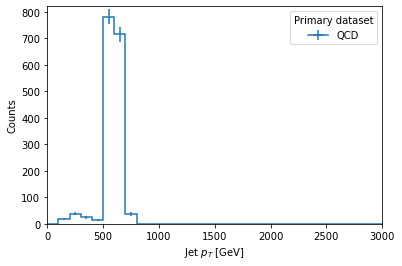

In [31]:
hist.plot1d(output_bkg['h_HOTVR'].sum('tagger'), overlay='dataset')

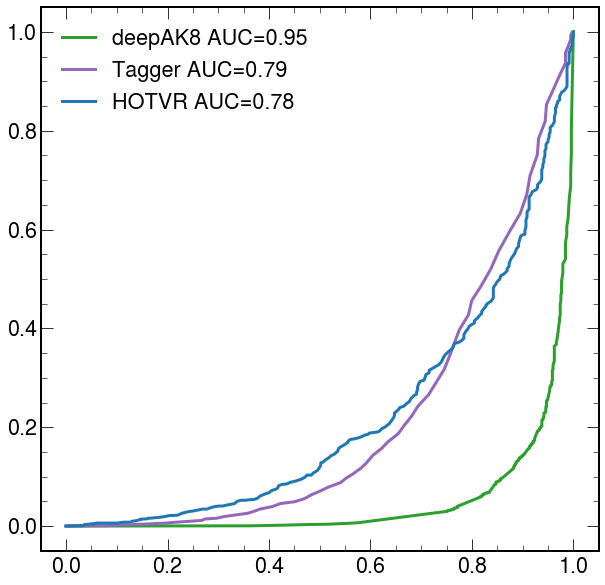

In [62]:
lw=3
sigmax = output_sig['h_deepAK8'].sum('dataset').sum('jetpt').sum('tagger').values()[()]
bkgmax = output_bkg['h_deepAK8'].sum('dataset').sum('jetpt').sum('tagger').values()[()]

ttbarmax = output_ttbar['h_deepAK8'].sum('dataset').sum('jetpt').sum('tagger').values()[()]


sigmax_H = output_sig['h_HOTVR'].sum('dataset').sum('jetpt').sum('tagger').values()[()]
bkgmax_H = output_bkg['h_HOTVR'].sum('dataset').sum('jetpt').sum('tagger').values()[()]


sig_H = (np.array(sig_H_values)/sigmax_H)[:-1]
bkg_H = (np.array(bkg_H_values)/bkgmax_H)[:-1]

roc_auc_H = auc(bkg_H, sig_H)


sig = (np.array(sig_values)/sigmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]
# sig_PN = (np.array(sig_values_PN)/sigmax)[:-1]
# bkg_PN =( np.array(bkg_values_PN)/bkgmax)[:-1]
sig_T = (np.array(sig_values_T)/sig_values_T[-1])
bkg_T =( np.array(bkg_values_T)/bkg_values_T[-1])

roc_auc_DA = auc(bkg, sig)
# roc_auc_PN = auc(bkg_PN, sig_PN)
roc_auc_T = auc(bkg_T, sig_T)

plt.plot(sig, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
# plt.plot(sig_PN, bkg_PN, color='C3', label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
plt.plot(sig_T, bkg_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))
plt.plot(sig_H, bkg_H, color='C0', lw=lw, label='HOTVR AUC={0:0.2f}'.format(roc_auc_H))


plt.legend()
# plt.yscale('log')
plt.show()

In [34]:
import mplhep as hep

In [108]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


taggerWPs = {
    'deepak801': 'DeepAK8 0.1% WP',
    'deepAK805': 'DeepAK8 0.5% WP',
    'deepAK810': 'DeepAK8 1.0% WP',
    'deepAK825': 'DeepAK8 2.5% WP',
    'tagger':    'Previous analysis WP',
    'hotvr':     'HOTVR WP',
    
}

efficiencies = {
    'deepak801': sig[find_nearest(sig_cuts, 0.920)[0]],
    'deepAK805': sig[find_nearest(sig_cuts, 0.685)[0]],
    'deepAK810': sig[find_nearest(sig_cuts, 0.470)[0]],
    'deepAK825': sig[find_nearest(sig_cuts, 0.174)[0]],
    'tagger':    sig_T[find_nearest(sig_cuts_T, 0.65)[0]],
    'hotvr':     sig_H[find_nearest(sig_cuts_H, 0.56)[0]],
    
}

mistagRates = {
    'deepak801': bkg[find_nearest(sig_cuts, 0.920)[0]],
    'deepAK805': bkg[find_nearest(sig_cuts, 0.685)[0]],
    'deepAK810': bkg[find_nearest(sig_cuts, 0.470)[0]],
    'deepAK825': bkg[find_nearest(sig_cuts, 0.174)[0]],
    'tagger':    bkg_T[find_nearest(sig_cuts_T, 0.65)[0]],
    'hotvr':     bkg_H[find_nearest(sig_cuts_H, 0.56)[0]],
    
}

# deepAK8_eff =   sig[find_nearest(sig_cuts, 0.920)[0]]
# deepAK8_eff05 = sig[find_nearest(sig_cuts, 0.685)[0]]
# deepAK8_eff10 = sig[find_nearest(sig_cuts, 0.470)[0]]
# deepAK8_eff25 = sig[find_nearest(sig_cuts, 0.174)[0]]

# tagger_eff = sig_T[find_nearest(sig_cuts_T, 0.65)[0]]

# hotvr_eff = sig_H[find_nearest(sig_cuts_H, 0.56)[0]]

# deepAK8_bkg = bkg[find_nearest(sig_cuts, 0.920)[0]]
# deepAK8_bkg05 = bkg[find_nearest(sig_cuts, 0.685)[0]]
# deepAK8_bkg10 = bkg[find_nearest(sig_cuts, 0.470)[0]]
# deepAK8_bkg25 = bkg[find_nearest(sig_cuts, 0.174)[0]]

# tagger_bkg  = bkg_T[find_nearest(sig_cuts_T, 0.65)[0]]

# hotvr_bkg   = bkg_H[find_nearest(sig_cuts_H, 0.56)[0]]



dfWP = pd.DataFrame(data={'tagger': taggerWPs.values(),
                   'signal eff (%)': [int(e*100) for e in efficiencies.values()], 
                   'mistag rate (%)': [int(r*100) for r in mistagRates.values()], 
                  })





In [109]:
[int(e*100) for e in efficiencies.values()]

[74, 84, 89, 95, 63, 76]

In [110]:
dfWP

,tagger,signal eff (%),mistag rate (%)
0,DeepAK8 0.1% WP,74,2
1,DeepAK8 0.5% WP,84,8
2,DeepAK8 1.0% WP,89,13
3,DeepAK8 2.5% WP,95,27
4,Previous analysis WP,63,17
5,HOTVR WP,76,36


In [111]:
print(dfWP.to_string(index=False))

              tagger  signal eff (%)  mistag rate (%)
     DeepAK8 0.1% WP              74                2
     DeepAK8 0.5% WP              84                8
     DeepAK8 1.0% WP              89               13
     DeepAK8 2.5% WP              95               27
Previous analysis WP              63               17
            HOTVR WP              76               36


In [112]:
find_nearest(sig_cuts, 0.920)[0]
sig_cuts[306]
sig_cuts[307]
sig[307]
bkg[307]

0.00726288806607804

In [70]:
print('efficiencies')
print('deepAK8', np.round(deepAK8_eff, 2))
print('tagger', np.round(tagger_eff,2 ))
print()
print('mistag rates')
# print('deepAK8', np.round(bkg[find_nearest(sig_cuts, 0.920)[0]], 2))
print('deepAK8', np.round(bkg[307], 3))

print('tagger', np.round(bkg_T[find_nearest(sig_cuts_T, 0.65)[0]], 2))

efficiencies
deepAK8 0.75
tagger 0.63

mistag rates
deepAK8 0.007
tagger 0.17


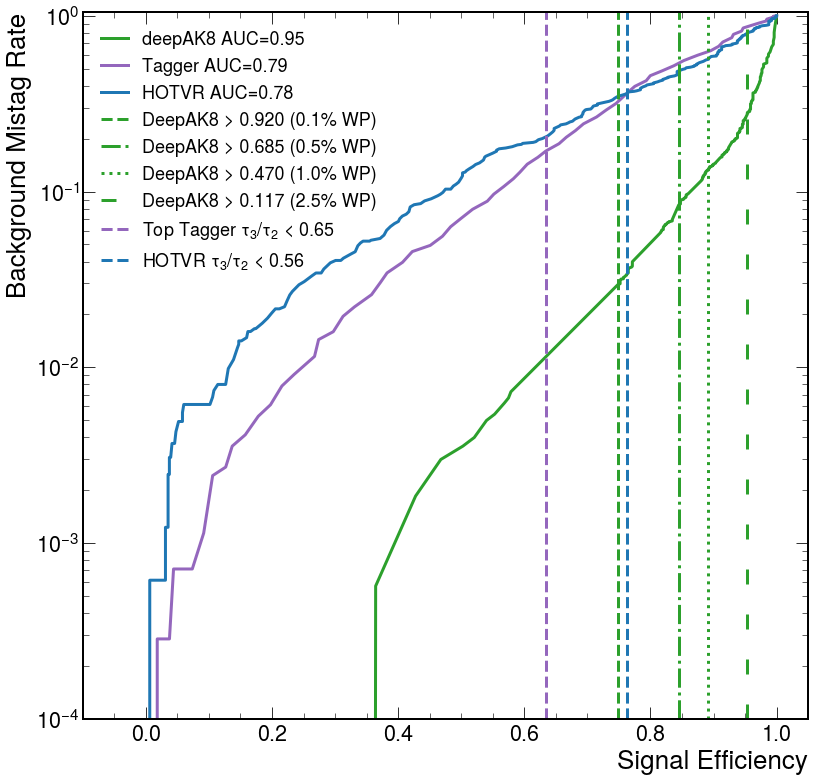

In [116]:

hep.style.use(hep.style.ROOT)

lw=3

color_H = 'C0'
color_T = 'C4'
color_D = 'C2'

with plt.style.context(hep.style.ROOT):
    
    plt.figure(figsize=(13,13))
    
    plt.plot(sig, bkg, color=color_D, lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
#     plt.plot(sig_PN, bkg_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
    plt.plot(sig_T, bkg_T, color=color_T, lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))
    plt.plot(sig_H, bkg_H, color=color_H, lw=lw, label='HOTVR AUC={0:0.2f}'.format(roc_auc_H))
#     plt.axhline(0.03, color='darkgreen', ls='--', lw=lw)
    plt.axvline(deepAK8_eff, color=color_D, ls='--', lw=lw, label='DeepAK8 > 0.920 (0.1% WP)')
    plt.axvline(deepAK8_eff05, color=color_D, ls='-.', lw=lw, label='DeepAK8 > 0.685 (0.5% WP)')
    plt.axvline(deepAK8_eff10, color=color_D, ls=':', lw=lw, label='DeepAK8 > 0.470 (1.0% WP)')
    plt.axvline(deepAK8_eff25, color=color_D, ls=(0, (5, 10)), lw=lw, label='DeepAK8 > 0.117 (2.5% WP)')


#     plt.axhline(0.15, color='purple', ls='--', lw=lw)
    plt.axvline(tagger_eff, color=color_T, ls='--', lw=lw, label=r'Top Tagger $\tau_3/\tau_2$ < 0.65')
    plt.axvline(hotvr_eff, color=color_H, ls='--', lw=lw, label=r'HOTVR $\tau_3/\tau_2$ < 0.56')



    
    plt.legend(fontsize=18,loc='upper left')
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlim(-0.1, 1.05)

    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [49]:
np.savez('ttbar_deepak8', sig=sig, bkg=bkg)

In [ ]:
np.savez('ttbar_ttagger', sig=sig_T, bkg=bkg_T, auc=roc_auc_T)

In [ ]:



hep.style.use(hep.style.ROOT)

lw=3

with plt.style.context(hep.style.ROOT):
    
    plt.plot(sig, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
#     plt.plot(sig_PN, bkg_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
    plt.plot(sig_T, bkg_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [ ]:
ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]
ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
bkg_PN =( np.array(bkg_values_PN)/bkgmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
bkg_T =( np.array(bkg_values_T)/bkgmax)


In [ ]:
ttbarmax = np.max(ttbar_values)
bkgmax = np.max(bkg_values)



ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]
# ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
# bkg_PN =( np.array(bkg_values_PN)/bkgmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
bkg_T =( np.array(bkg_values_T)/bkgmax)

lw=3


roc_ttbar_DA = auc(bkg, ttbar)
# roc_auc_PN = auc(bkg_PN, sig_PN)
roc_ttbar_T = auc(bkg_T, ttbar_T)

with plt.style.context(hep.style.ROOT):
    
    plt.plot(ttbar, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_ttbar_DA))
#     plt.plot(ttbar_PN, bkg_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
    plt.plot(ttbar_T, bkg_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_ttbar_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [ ]:
ttbarmax = np.max(ttbar_values)
wjetsmax = np.max(wjets_values)



ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
wjets = (np.array(wjets_values)/wjetsmax)[:-1]
# ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
# wjets_PN =( np.array(wjets_values_PN)/wjetsmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
wjets_T =( np.array(wjets_values_T)/wjetsmax)

lw=3

with plt.style.context(hep.style.ROOT):
    
    plt.plot(ttbar, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
    plt.plot(ttbar_T, bkg_T, color='C4', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_T))

#     plt.plot(ttbar_PN, wjets_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
#     plt.plot(ttbar_T, wjets_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [ ]:
946934 / 27304804

In [ ]:
output_sig['cutflow']

In [ ]:
hist.plot1d(output_sig['jetpt'].sum('dataset'))

In [ ]:
hist.plot1d(output_sig['ttbarcands_mass'].sum('dataset'))

In [ ]:
hist.plot1d(output_sig['ttbarcands_pt'].sum('dataset'))

In [ ]:
hist.plot1d(output_bkg['jetpt'].sum('dataset'))

In [ ]:
output_sig['cutflow']

output_sig['ttjets']['all']